In [1]:
# focus 3D

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import supplementary_code as sc

from ipywidgets import interact
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy import ndimage as ndi
from scipy import stats

from skimage import (color, data, exposure, feature, filters, io, measure,
                    morphology, restoration, segmentation, transform,
                    util)

%matplotlib inline

In [11]:
data, rescaled, equalized = sc.results_from_part_1()

In [12]:
from skimage.external import tifffile
inputfile = 'images/cells_interior_labels.tiff'
relabeled = tifffile.imread(inputfile)

In [16]:
relabeled.shape

(60, 256, 256)

In [13]:
regionprops = measure.regionprops(relabeled, intensity_image=data)

RuntimeError: data type not supported

In [17]:
selected_cell = 3

# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px, faces_px, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=(1.0, 1.0, 1.0))
surface_area_pixels = measure.mesh_surface_area(verts_px, faces_px)

verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=tuple(spacing))
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("Surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("Surface area (actual): {:0.2f}".format(surface_area_actual))

NameError: name 'regionprops' is not defined

In [ ]:
The volume can be visualized using the mesh vertexes and faces.

NameError: name 'verts_px' is not defined

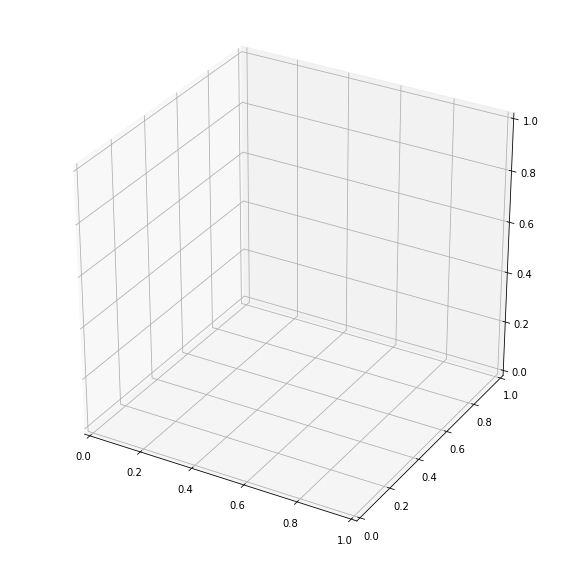

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts_px[faces_px])
mesh.set_edgecolor("black")
ax.add_collection3d(mesh)

ax.set_xlabel("col")
ax.set_ylabel("row")
ax.set_zlabel("pln")

min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)

plt.tight_layout()
plt.show()

In [ ]:
import itk
from itkwidgets import view
file_name = '/Users/dani/Dropbox/prog/Apps_IDEAL/concrete/code/bat.tif'
image = itk.imread(file_name) #, pixelType=itk.ctype('float'))
#itk.GetImageViewFromArray(imageBlock.astype(np.float64))
#itk.GetImageViewFromArray(image[:,:,:])
view(image, slicing_planes=False)

#showing full stack

In [ ]:
imageBlock = ic[::10].concatenate()
imageBlock = imageBlock==217#label(image[100:600,300:400,100:200])#1000:1100])
imageBlock = imageBlock[:,::10,::10]
imageBlock.shape


In [ ]:
imageBlock = imageBlock.astype(np.uint8)

In [ ]:
import itk
from itkwidgets import view
#file_name = '/Users/dani/Documents/data/fibers/materialsFacility/alex_fibers/snapshots/binary_ndown10.tif'
#image = itk.imread(file_name)
#itk.GetImageViewFromArray(imageBlock.astype(np.float64))
#itk.GetImageViewFromArray(image[:,:,:])
view(imageBlock, slicing_planes=True)

#showing full stack